In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import xgboost
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data_path = '/home/mvkrein/etf_model/data'
etf_data_file = os.path.join(data_path,'etf_new_var_20180910.csv')
etf_data = pd.read_csv(etf_data_file,index_col=0)

In [4]:
etf_study_file = os.path.join(data_path,'ETF_list_min_6yr_history.csv')
etf_list = pd.read_csv(etf_study_file,index_col=0)
etf_data.sort_values(['Date','sym'],ascending=True,inplace=True)
etf_data.reset_index(drop=True,inplace=True)

In [5]:
drop_columns = ['Date','sym','p', 'v', 'p_L05', 'v_L05', 'p_L10', 'v_L10', 'p_L21', 'v_L21', 'p_L42', 'v_L42', 'p_L63', \
                'v_L63', 'p_L84', 'v_L84', 'p_L126', 'v_L126', 'p_L189', 'v_L189', 'p_L252', 'v_L252',\
                'p_L-21', 'v_L-21', 'delta_p_L05', 'delta_p_L10', 'delta_p_L21', 'delta_p_L42', 'delta_p_L63', \
                'delta_p_L84', 'delta_p_L126', 'delta_p_L189', 'delta_p_L252', 'delta_p_L-21', 'delta_v_L05',\
                'delta_v_L10', 'delta_v_L21', 'delta_v_L42', 'delta_v_L63', 'delta_v_L84', 'delta_v_L126', \
                'delta_v_L189', 'delta_v_L252','rank_p_L-21', 'ivv_delta_p_L-21', 'target']

rank_col = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
            'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']

In [6]:
all_columns = list(etf_data.columns)

In [7]:
include_columns = [x for x in all_columns if x not in drop_columns]
# include_columns = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
#             'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']
# include_columns = ['rank_p_L05','rank_p_L21','rank_p_L42','rank_p_L252']

In [8]:
len(include_columns)

360

In [9]:
dates = list(etf_data['Date'].unique())
# dates[1671]

In [10]:
symbols = etf_list['Symbol'].unique()

In [11]:
len(symbols)

153

In [12]:
#Each year has 252 trading dates.  Need two years to fully develop variables.
dt1 = 504 #This is the first day that all variables are developed
# dt1 = 504 + 21 + 273 #This is the first day that all variables are developed 2016-04-07
# make all dates relative to dt1
# for one year training - add 252
# to evaluate for one month outside the training window - add 273
# to predict for the first day outside of the evaluation window (have to lag 21) - add 294
dt_end = (len(dates) - 273 - 21) - 1
# dt_end = dt1 + 1
#etf_predict_file = os.path.join(data_path,'etf_pred_ridge_20180920.csv')
k = 0

In [13]:

for i in range(dt1,dt_end):
    print("Building model to predict for ",dates[i+273])
    x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
    y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

    x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
    y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
    returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
    mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
    x_train_nmpy = x_train.as_matrix()
    y_train_nmpy = np.ravel(y_train.as_matrix())

    x_test_nmpy = x_test.as_matrix()
    y_test_nmpy = np.ravel(y_test.as_matrix())
    returns_nmpy = returns.as_matrix()
    mkt_return_nmpy = mkt_return.as_matrix()

#     lm = linear_model.Ridge (alpha = 0.8)
    lm = linear_model.Lasso (alpha = 0.00019)

    lm.fit(x_train_nmpy, y_train_nmpy)
    
    y_pred_model = lm.predict(x_test_nmpy)


    y_check = np.column_stack((y_test_nmpy, y_pred_model,mkt_return_nmpy,returns_nmpy))
    y_check_df = pd.DataFrame(y_check,columns=['true_value','pred_value','mkt_return','returns'])
    y_check_df.sort_values('pred_value',inplace=True,ascending=False)
    

    train_error = mean_squared_error(y_train_nmpy,lm.predict(x_train_nmpy))
    eval_error = mean_squared_error(y_test_nmpy,y_pred_model)

    print('Model Eval Results:')
    print('*****************************')

    print(f'training error: {train_error:.3}')
    print(f'evaluation error: {eval_error:.3}')
    print('R-squared score (training): {:.3f}'
     .format(lm.score(x_train_nmpy, y_train_nmpy)))
    print('R-squared score (test): {:.3f}'
     .format(lm.score(x_test_nmpy, y_test_nmpy)))

    print('*****************************')
    print("Model Top 5 Picks")
    print(" Avg rtn top 5:", round(y_check_df['returns'][0:5].mean(),4))
    print(y_check_df.head(5))
    print("Model Bottom 5 Picks")
    print(" Avg rtn bottom 5:", round(y_check_df['returns'][-5:].mean(),4))
    print(y_check_df.tail(5))
    print('********************************************************')
    etf_predict_file = os.path.join(data_path,('etf_pred_linear_lasso_20181002_'+str(k%21)+'.csv'))
    if k < 21:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file)
    else:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file,header=False,mode='a')
    k+=1

Building model to predict for  2015-02-05
Model Eval Results:
*****************************
training error: 0.0747
evaluation error: 0.0635
R-squared score (training): 0.103
R-squared score (test): 0.238
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0497
     true_value  pred_value  mkt_return   returns
139    0.960784    0.687726    0.010741  0.060291
70     0.986928    0.671993    0.010741  0.071770
67     0.882353    0.642061    0.010741  0.031835
45     0.888889    0.639172    0.010741  0.036401
66     0.947712    0.637022    0.010741  0.048248
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0258
    true_value  pred_value  mkt_return   returns
62    0.418301    0.383973    0.010741 -0.006829
26    0.424837    0.378687    0.010741 -0.006699
57    0.039216    0.363467    0.010741 -0.085190
39    0.287582    0.345077    0.010741 -0.016544
23    0.326797    0.294466    0.010741 -0.013518
********************************************************
Building model to predict 

Model Eval Results:
*****************************
training error: 0.0739
evaluation error: 0.0736
R-squared score (training): 0.112
R-squared score (test): 0.117
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.049
     true_value  pred_value  mkt_return   returns
70     0.993464    0.664044    0.006621  0.104009
126    0.692810    0.610834    0.006621  0.016114
88     0.980392    0.609540    0.006621  0.079491
38     0.941176    0.605852    0.006621  0.039863
12     0.385621    0.595055    0.006621  0.005597
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0249
     true_value  pred_value  mkt_return   returns
32     0.032680    0.347665    0.006621 -0.066906
62     0.039216    0.346929    0.006621 -0.064269
37     0.346405    0.340228    0.006621  0.004742
104    0.535948    0.314633    0.006621  0.009434
23     0.222222    0.258130    0.006621 -0.007625
********************************************************
Building model to predict for  2015-02-20
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0724
evaluation error: 0.0805
R-squared score (training): 0.131
R-squared score (test): 0.034
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0479
     true_value  pred_value  mkt_return   returns
126    0.993464    0.679102    -0.01398  0.089161
6      0.901961    0.632217    -0.01398  0.033000
60     0.986928    0.627396    -0.01398  0.086626
70     0.281046    0.614970    -0.01398 -0.001147
0      0.869281    0.613290    -0.01398  0.032085
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0135
     true_value  pred_value  mkt_return   returns
84     0.052288    0.376742    -0.01398 -0.030048
62     0.006536    0.350767    -0.01398 -0.048991
132    0.679739    0.346176    -0.01398  0.015272
37     0.104575    0.325205    -0.01398 -0.016322
23     0.614379    0.279359    -0.01398  0.012454
********************************************************
Building model to predict for  2015-03-05
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0708
evaluation error: 0.0815
R-squared score (training): 0.149
R-squared score (test): 0.022
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.061
     true_value  pred_value  mkt_return   returns
57     0.875817    0.729553    0.016185  0.103373
39     0.947712    0.707235    0.016185  0.129524
96     0.444444    0.644721    0.016185  0.021173
103    0.169935    0.638188    0.016185  0.010985
79     0.607843    0.635193    0.016185  0.040103
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0706
     true_value  pred_value  mkt_return   returns
101    0.117647    0.367010    0.016185  0.005846
62     0.921569    0.366939    0.016185  0.112046
23     0.568627    0.339472    0.016185  0.033234
132    0.549020    0.337242    0.016185  0.031725
55     0.960784    0.334570    0.016185  0.170029
********************************************************
Building model to predict for  2015-03-18
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0699
evaluation error: 0.0914
R-squared score (training): 0.160
R-squared score (test): -0.097
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0355
     true_value  pred_value  mkt_return   returns
103    0.078431    0.751378    0.011306 -0.020747
57     0.888889    0.746493    0.011306  0.073211
39     0.901961    0.717842    0.011306  0.082390
46     0.823529    0.685187    0.011306  0.061160
70     0.084967    0.684951    0.011306 -0.018530
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0865
     true_value  pred_value  mkt_return   returns
146    0.045752    0.293019    0.011306 -0.033869
54     0.993464    0.278140    0.011306  0.170795
97     0.947712    0.263580    0.011306  0.111719
55     0.967320    0.259074    0.011306  0.152700
148    0.725490    0.226540    0.011306  0.031297
********************************************************
Building model to predict for  2015-03-31
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0702
evaluation error: 0.074
R-squared score (training): 0.157
R-squared score (test): 0.095
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.032
    true_value  pred_value  mkt_return   returns
46    0.960784    0.820598    0.004229  0.066543
33    0.875817    0.769198    0.004229  0.029487
40    0.895425    0.755968    0.004229  0.031354
37    0.692810    0.749209    0.004229  0.008971
47    0.823529    0.747975    0.004229  0.023593
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0188
     true_value  pred_value  mkt_return   returns
148    0.934641    0.215451    0.004229  0.055786
55     0.797386    0.213381    0.004229  0.021441
98     0.032680    0.212522    0.004229 -0.064531
145    0.065359    0.197094    0.004229 -0.031783
146    0.013072    0.140038    0.004229 -0.074838
********************************************************
Building model to predict for  2015-04-14
Model Eval Results:
********

Model Eval Results:
*****************************
training error: 0.0699
evaluation error: 0.0709
R-squared score (training): 0.160
R-squared score (test): 0.149
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0126
     true_value  pred_value  mkt_return   returns
66     0.941176    0.838440   -0.004459  0.012836
47     0.274510    0.823419   -0.004459 -0.020119
33     0.921569    0.799408   -0.004459  0.009737
117    0.967320    0.787465   -0.004459  0.027527
68     0.986928    0.776325   -0.004459  0.033266
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0486
     true_value  pred_value  mkt_return   returns
18     0.150327    0.245021   -0.004459 -0.034292
146    0.071895    0.241592   -0.004459 -0.049265
57     0.039216    0.238576   -0.004459 -0.061652
55     0.013072    0.210296   -0.004459 -0.105512
148    0.908497    0.163287   -0.004459  0.007622
********************************************************
Building model to predict for  2015-04-27
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0695
evaluation error: 0.0562
R-squared score (training): 0.166
R-squared score (test): 0.326
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0015
    true_value  pred_value  mkt_return   returns
66    0.967320    0.865942   -0.001902  0.038891
47    0.281046    0.777095   -0.001902 -0.023092
72    0.052288    0.749825   -0.001902 -0.069268
25    0.921569    0.724551   -0.001902  0.025511
88    0.960784    0.704083   -0.001902  0.035501
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.05
     true_value  pred_value  mkt_return   returns
55     0.111111    0.320885   -0.001902 -0.050082
143    0.352941    0.264029   -0.001902 -0.016112
80     0.235294    0.226267   -0.001902 -0.029327
57     0.032680    0.168287   -0.001902 -0.086982
148    0.058824    0.136310   -0.001902 -0.067742
********************************************************
Building model to predict for  2015-05-08
Model Eval Results:
********

Model Eval Results:
*****************************
training error: 0.0684
evaluation error: 0.0831
R-squared score (training): 0.178
R-squared score (test): 0.003
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0163
     true_value  pred_value  mkt_return   returns
25     0.725490    0.775780   -0.006953 -0.002659
72     0.098039    0.765801   -0.006953 -0.059822
15     0.202614    0.712617   -0.006953 -0.042612
132    0.392157    0.693781   -0.006953 -0.021386
112    1.000000    0.680183   -0.006953  0.045158
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0479
     true_value  pred_value  mkt_return   returns
80     0.189542    0.339598   -0.006953 -0.044017
37     0.509804    0.332410   -0.006953 -0.009881
62     0.326797    0.329274   -0.006953 -0.025858
79     0.084967    0.315939   -0.006953 -0.061443
148    0.006536    0.247442   -0.006953 -0.098434
********************************************************
Building model to predict for  2015-05-21
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0669
evaluation error: 0.0956
R-squared score (training): 0.196
R-squared score (test): -0.147
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0423
    true_value  pred_value  mkt_return   returns
54    0.947712    0.766010   -0.017036  0.009514
25    0.934641    0.753175   -0.017036  0.004998
72    0.045752    0.744961   -0.017036 -0.064295
15    0.006536    0.737836   -0.017036 -0.162766
97    0.849673    0.702233   -0.017036  0.000829
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0365
     true_value  pred_value  mkt_return   returns
46     0.039216    0.356336   -0.017036 -0.068197
139    0.052288    0.323762   -0.017036 -0.063819
62     0.575163    0.320695   -0.017036 -0.013314
104    0.980392    0.305429   -0.017036  0.025005
37     0.058824    0.269634   -0.017036 -0.062000
********************************************************
Building model to predict for  2015-06-04
Model Eval Results:
****

Model Eval Results:
*****************************
training error: 0.066
evaluation error: 0.117
R-squared score (training): 0.207
R-squared score (test): -0.406
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0395
    true_value  pred_value  mkt_return   returns
54    0.130719    0.858173    0.014324 -0.026476
55    0.209150    0.827855    0.014324 -0.019393
75    0.052288    0.815819    0.014324 -0.067319
81    0.071895    0.807784    0.014324 -0.063287
97    0.196078    0.791097    0.014324 -0.021006
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0013
     true_value  pred_value  mkt_return   returns
96     0.653595    0.331675    0.014324  0.008228
67     0.947712    0.329918    0.014324  0.032700
38     0.875817    0.326190    0.014324  0.024489
134    0.568627    0.294437    0.014324  0.005091
139    0.058824    0.268147    0.014324 -0.063940
********************************************************
Building model to predict for  2015-06-17
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.065
evaluation error: 0.0949
R-squared score (training): 0.219
R-squared score (test): -0.138
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0687
     true_value  pred_value  mkt_return   returns
15     0.013072    0.774714    0.025744 -0.119943
54     0.026144    0.734046    0.025744 -0.105474
29     0.274510    0.709570    0.025744 -0.014991
55     0.006536    0.709418    0.025744 -0.125798
120    0.790850    0.682445    0.025744  0.022659
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0134
     true_value  pred_value  mkt_return   returns
146    0.823529    0.338534    0.025744  0.023650
114    0.267974    0.328908    0.025744 -0.015302
96     0.464052    0.320514    0.025744  0.003832
88     0.960784    0.296677    0.025744  0.048888
134    0.549020    0.242772    0.025744  0.005815
********************************************************
Building model to predict for  2015-06-30
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0643
evaluation error: 0.0836
R-squared score (training): 0.228
R-squared score (test): -0.003
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0157
     true_value  pred_value  mkt_return   returns
84     0.738562    0.797763   -0.005543  0.004447
120    0.633987    0.777993   -0.005543 -0.001302
15     0.156863    0.747740   -0.005543 -0.058540
139    0.248366    0.726815   -0.005543 -0.038051
83     0.895425    0.724453   -0.005543  0.014908
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.055
     true_value  pred_value  mkt_return   returns
0      0.124183    0.213559   -0.005543 -0.062713
6      0.150327    0.191997   -0.005543 -0.060234
126    0.196078    0.144203   -0.005543 -0.042436
60     0.176471    0.129510   -0.005543 -0.047075
11     0.130719    0.076453   -0.005543 -0.062708
********************************************************
Building model to predict for  2015-07-14
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0641
evaluation error: 0.0759
R-squared score (training): 0.230
R-squared score (test): 0.089
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0848
     true_value  pred_value  mkt_return   returns
139    0.222222    0.930735    -0.08951 -0.117079
84     0.281046    0.831765    -0.08951 -0.103996
103    0.718954    0.795766    -0.08951 -0.049562
120    0.496732    0.787201    -0.08951 -0.083525
95     0.627451    0.766654    -0.08951 -0.069753
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.1701
     true_value  pred_value  mkt_return   returns
18     0.156863    0.107994    -0.08951 -0.142419
32     0.098039    0.068006    -0.08951 -0.162224
126    0.032680    0.037354    -0.08951 -0.193755
60     0.065359    0.035721    -0.08951 -0.180925
11     0.071895   -0.081905    -0.08951 -0.171330
********************************************************
Building model to predict for  2015-07-27
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0633
evaluation error: 0.0688
R-squared score (training): 0.239
R-squared score (test): 0.175
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0458
     true_value  pred_value  mkt_return   returns
104    0.947712    0.863565   -0.076446  0.005111
95     0.686275    0.819192   -0.076446 -0.060969
139    0.725490    0.810470   -0.076446 -0.053717
103    0.712418    0.801994   -0.076446 -0.054852
114    0.647059    0.780815   -0.076446 -0.064639
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.1261
     true_value  pred_value  mkt_return   returns
60     0.013072    0.121976   -0.076446 -0.162802
18     0.228758    0.119204   -0.076446 -0.105676
126    0.032680    0.113233   -0.076446 -0.154767
32     0.673203    0.057259   -0.076446 -0.063880
11     0.071895   -0.106518   -0.076446 -0.143239
********************************************************
Building model to predict for  2015-08-07
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0622
evaluation error: 0.108
R-squared score (training): 0.252
R-squared score (test): -0.297
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0491
     true_value  pred_value  mkt_return   returns
104    0.307190    0.807724   -0.057165 -0.055481
133    0.529412    0.735727   -0.057165 -0.043217
90     0.254902    0.724624   -0.057165 -0.056840
88     0.627451    0.715814   -0.057165 -0.027850
103    0.150327    0.706418   -0.057165 -0.062011
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0199
    true_value  pred_value  mkt_return   returns
17    0.673203    0.221213   -0.057165 -0.019162
6     0.705882    0.219383   -0.057165 -0.015804
78    0.633987    0.193208   -0.057165 -0.027523
32    0.973856    0.086927   -0.057165  0.024855
11    0.156863    0.069055   -0.057165 -0.061801
********************************************************
Building model to predict for  2015-08-20
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0622
evaluation error: 0.0838
R-squared score (training): 0.252
R-squared score (test): -0.006
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0416
     true_value  pred_value  mkt_return   returns
133    0.993464    0.810176    0.008239  0.066666
71     0.986928    0.789953    0.008239  0.064331
79     0.882353    0.771812    0.008239  0.022739
151    0.954248    0.747829    0.008239  0.037758
146    0.843137    0.739379    0.008239  0.016693
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0384
     true_value  pred_value  mkt_return   returns
101    0.058824    0.238987    0.008239 -0.046644
11     0.856209    0.221189    0.008239  0.017747
62     0.196078    0.218891    0.008239 -0.020208
32     0.209150    0.201972    0.008239 -0.018961
78     0.006536    0.193713    0.008239 -0.123725
********************************************************
Building model to predict for  2015-09-02
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0626
evaluation error: 0.0896
R-squared score (training): 0.247
R-squared score (test): -0.076
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0715
     true_value  pred_value  mkt_return   returns
79     0.901961    0.860686    0.009205  0.059292
133    0.895425    0.737558    0.009205  0.057805
71     0.921569    0.727082    0.009205  0.062199
148    0.993464    0.725318    0.009205  0.118512
151    0.908497    0.724769    0.009205  0.059884
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0163
     true_value  pred_value  mkt_return   returns
126    0.843137    0.308417    0.009205  0.047587
62     0.398693    0.282291    0.009205  0.009913
78     0.823529    0.278213    0.009205  0.046059
101    0.019608    0.272568    0.009205 -0.066577
11     0.803922    0.261292    0.009205  0.044379
********************************************************
Building model to predict for  2015-09-16
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0639
evaluation error: 0.0992
R-squared score (training): 0.233
R-squared score (test): -0.190
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0811
     true_value  pred_value  mkt_return   returns
79     0.411765    0.856419    0.099307  0.067977
148    0.934641    0.746244    0.099307  0.134222
80     0.372549    0.698234    0.099307  0.062004
20     0.405229    0.692325    0.099307  0.067777
2      0.483660    0.662065    0.099307  0.073726
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0614
     true_value  pred_value  mkt_return   returns
15     0.960784    0.291921    0.099307  0.136635
78     0.522876    0.287919    0.099307  0.081029
66     0.392157    0.283926    0.099307  0.065435
62     0.006536    0.260731    0.099307 -0.022485
112    0.254902    0.232861    0.099307  0.046193
********************************************************
Building model to predict for  2015-09-29
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0645
evaluation error: 0.0805
R-squared score (training): 0.225
R-squared score (test): 0.034
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0139
     true_value  pred_value  mkt_return   returns
79     0.254902    0.786377    0.033136 -0.029630
131    0.705882    0.646984    0.033136  0.009296
121    0.699346    0.646449    0.033136  0.009079
103    0.810458    0.642475    0.033136  0.020102
90     0.960784    0.631205    0.033136  0.060774
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0263
     true_value  pred_value  mkt_return   returns
44     0.013072    0.272424    0.033136 -0.092940
126    0.470588    0.267977    0.033136 -0.005890
17     0.196078    0.260124    0.033136 -0.036736
60     0.366013    0.254742    0.033136 -0.012675
15     0.771242    0.196807    0.033136  0.016816
********************************************************
Building model to predict for  2015-10-12
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.065
evaluation error: 0.0793
R-squared score (training): 0.219
R-squared score (test): 0.049
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0161
     true_value  pred_value  mkt_return   returns
143    0.169935    0.709608    0.020743 -0.030975
92     0.699346    0.663143    0.020743  0.009046
139    0.385621    0.653722    0.020743 -0.012597
103    0.928105    0.649687    0.020743  0.035557
62     0.013072    0.646579    0.020743 -0.081368
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0275
     true_value  pred_value  mkt_return   returns
47     0.058824    0.363613    0.020743 -0.055797
44     0.156863    0.353200    0.020743 -0.031336
126    0.294118    0.297586    0.020743 -0.020200
60     0.163399    0.288106    0.020743 -0.030982
15     0.581699    0.214093    0.020743  0.000650
********************************************************
Building model to predict for  2015-10-23
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0652
evaluation error: 0.098
R-squared score (training): 0.217
R-squared score (test): -0.176
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0377
     true_value  pred_value  mkt_return   returns
143    0.091503    0.845038   -0.003687 -0.057326
50     0.084967    0.825343   -0.003687 -0.057692
62     0.026144    0.727150   -0.003687 -0.094929
139    0.947712    0.716341   -0.003687  0.028113
89     0.444444    0.662159   -0.003687 -0.006480
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0197
    true_value  pred_value  mkt_return   returns
58    0.366013    0.340657   -0.003687 -0.010321
51    0.169935    0.335746   -0.003687 -0.036261
47    0.241830    0.334160   -0.003687 -0.020913
48    0.196078    0.263068   -0.003687 -0.029400
15    0.653595    0.252169   -0.003687 -0.001742
********************************************************
Building model to predict for  2015-11-05
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0657
evaluation error: 0.113
R-squared score (training): 0.210
R-squared score (test): -0.351
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0123
     true_value  pred_value  mkt_return   returns
50     0.202614    0.875499   -0.002275 -0.026451
99     0.444444    0.808416   -0.002275 -0.011074
143    0.065359    0.805111   -0.002275 -0.072484
72     1.000000    0.766566   -0.002275  0.067742
0      0.294118    0.762755   -0.002275 -0.019398
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0101
     true_value  pred_value  mkt_return   returns
136    0.725490    0.305446   -0.002275 -0.000309
24     0.973856    0.295933   -0.002275  0.044895
85     0.875817    0.286938   -0.002275  0.007134
102    0.869281    0.284060   -0.002275  0.007048
55     0.026144    0.260113   -0.002275 -0.109317
********************************************************
Building model to predict for  2015-11-18
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0659
evaluation error: 0.122
R-squared score (training): 0.208
R-squared score (test): -0.462
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0242
    true_value  pred_value  mkt_return   returns
11    0.307190    0.884377   -0.026878 -0.037540
15    0.862745    0.830748   -0.026878 -0.002639
39    0.653595    0.830427   -0.026878 -0.015421
72    0.993464    0.823127   -0.026878  0.036176
57    0.039216    0.808572   -0.026878 -0.101772
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0021
     true_value  pred_value  mkt_return   returns
59     0.908497    0.274212   -0.026878  0.001131
138    0.542484    0.270621   -0.026878 -0.023686
69     0.758170    0.241558   -0.026878 -0.007759
102    0.954248    0.235999   -0.026878  0.013923
24     0.986928    0.228033   -0.026878  0.026691
********************************************************
Building model to predict for  2015-12-02
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0662
evaluation error: 0.152
R-squared score (training): 0.205
R-squared score (test): -0.830
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0702
     true_value  pred_value  mkt_return   returns
15     0.418301    0.888560    -0.04945 -0.049373
11     0.143791    0.853771    -0.04945 -0.080612
126    0.078431    0.831497    -0.04945 -0.092119
72     0.163399    0.821600    -0.04945 -0.076056
39     0.359477    0.818581    -0.04945 -0.053080
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0018
     true_value  pred_value  mkt_return   returns
140    0.849673    0.202763    -0.04945  0.004053
86     0.830065    0.198580    -0.04945  0.001598
137    0.843137    0.181873    -0.04945  0.002641
136    0.816993    0.172483    -0.04945  0.000735
59     0.810458    0.170136    -0.04945  0.000139
********************************************************
Building model to predict for  2015-12-15
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0663
evaluation error: 0.106
R-squared score (training): 0.203
R-squared score (test): -0.278
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.1137
     true_value  pred_value  mkt_return   returns
15     0.013072    0.755483   -0.077806 -0.168895
41     0.581699    0.748297   -0.077806 -0.074196
72     0.032680    0.707041   -0.077806 -0.154389
39     0.143791    0.677805   -0.077806 -0.116490
134    0.679739    0.655535   -0.077806 -0.054380
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0348
     true_value  pred_value  mkt_return   returns
44     0.954248    0.351909   -0.077806  0.011703
27     0.660131    0.350509   -0.077806 -0.058394
102    0.830065    0.349864   -0.077806 -0.001788
32     0.784314    0.334765   -0.077806 -0.018050
75     0.196078    0.322601   -0.077806 -0.107386
********************************************************
Building model to predict for  2015-12-29
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0663
evaluation error: 0.101
R-squared score (training): 0.204
R-squared score (test): -0.210
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0845
     true_value  pred_value  mkt_return   returns
117    0.045752    0.694369   -0.035642 -0.102875
83     0.124183    0.657765   -0.035642 -0.077438
41     0.098039    0.650708   -0.035642 -0.085938
84     0.039216    0.649113   -0.035642 -0.111013
67     0.352941    0.631368   -0.035642 -0.045321
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0342
    true_value  pred_value  mkt_return   returns
35    0.627451    0.298410   -0.035642 -0.014101
44    0.967320    0.295297   -0.035642  0.078404
53    0.660131    0.293275   -0.035642 -0.006561
27    0.758170    0.283604   -0.035642  0.006014
23    1.000000    0.232629   -0.035642  0.107479
********************************************************
Building model to predict for  2016-01-12
Model Eval Results:
******

/home/mvkrein/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Model Eval Results:
*****************************
training error: 0.0661
evaluation error: 0.112
R-squared score (training): 0.206
R-squared score (test): -0.347
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0144
     true_value  pred_value  mkt_return   returns
117    0.071895    0.695087    0.026968 -0.021010
83     0.418301    0.682268    0.026968  0.016090
68     0.098039    0.674788    0.026968 -0.012286
104    0.143791    0.659581    0.026968 -0.005539
118    0.908497    0.635221    0.026968  0.094583
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.074
     true_value  pred_value  mkt_return   returns
35     0.882353    0.330918    0.026968  0.083077
53     0.751634    0.306206    0.026968  0.041547
148    0.856209    0.277087    0.026968  0.063501
23     0.980392    0.245879    0.026968  0.149751
27     0.647059    0.241085    0.026968  0.032211
********************************************************
Building model to predict for  2016-01-19
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0659
evaluation error: 0.107
R-squared score (training): 0.208
R-squared score (test): -0.286
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0026
     true_value  pred_value  mkt_return   returns
73     0.352941    0.776375    0.023482  0.006927
145    0.385621    0.767182    0.023482  0.008503
125    0.228758    0.762742    0.023482  0.000651
12     0.189542    0.761542    0.023482 -0.001507
127    0.183007    0.751145    0.023482 -0.001663
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0144
    true_value  pred_value  mkt_return   returns
58    0.078431    0.295313    0.023482 -0.011446
38    0.150327    0.272727    0.023482 -0.003699
11    0.535948    0.256409    0.023482  0.018065
48    0.202614    0.239541    0.023482 -0.000429
23    0.954248    0.229756    0.023482  0.069746
********************************************************
Building model to predict for  2016-02-01
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0658
evaluation error: 0.107
R-squared score (training): 0.209
R-squared score (test): -0.288
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0268
     true_value  pred_value  mkt_return   returns
146    0.006536    0.735016    0.107327 -0.042758
145    0.013072    0.720210    0.107327 -0.027369
73     0.019608    0.707187    0.107327 -0.025090
133    0.816993    0.682618    0.107327  0.145766
150    0.287582    0.668666    0.107327  0.083334
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.1213
    true_value  pred_value  mkt_return   returns
70    0.248366    0.327164    0.107327  0.071300
40    0.895425    0.326251    0.107327  0.163569
46    0.836601    0.299651    0.107327  0.150037
38    0.411765    0.294048    0.107327  0.103629
48    0.588235    0.289858    0.107327  0.118027
********************************************************
Building model to predict for  2016-02-12
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0672
evaluation error: 0.0905
R-squared score (training): 0.193
R-squared score (test): -0.086
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0763
     true_value  pred_value  mkt_return   returns
71     0.745098    0.718962      0.0454  0.069915
99     0.954248    0.705895      0.0454  0.118774
15     0.405229    0.701065      0.0454  0.043925
151    0.777778    0.695975      0.0454  0.072163
133    0.790850    0.685036      0.0454  0.076930
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0497
     true_value  pred_value  mkt_return   returns
40     0.803922    0.306508      0.0454  0.077945
65     0.287582    0.292275      0.0454  0.034379
135    0.588235    0.288553      0.0454  0.056153
102    0.163399    0.254342      0.0454  0.013683
46     0.699346    0.247863      0.0454  0.066433
********************************************************
Building model to predict for  2016-02-26
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0682
evaluation error: 0.0906
R-squared score (training): 0.181
R-squared score (test): -0.087
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0198
     true_value  pred_value  mkt_return   returns
117    0.098039    0.803006    0.031375 -0.000522
67     0.313725    0.754370    0.031375  0.017336
71     0.934641    0.752469    0.031375  0.059119
66     0.026144    0.738536    0.031375 -0.024476
87     0.856209    0.727947    0.031375  0.047574
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0271
     true_value  pred_value  mkt_return   returns
29     0.895425    0.287494    0.031375  0.053151
46     0.875817    0.264996    0.031375  0.050607
102    0.686275    0.254117    0.031375  0.035455
69     0.058824    0.223667    0.031375 -0.009934
138    0.150327    0.174518    0.031375  0.006194
********************************************************
Building model to predict for  2016-03-10
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0674
evaluation error: 0.0807
R-squared score (training): 0.190
R-squared score (test): 0.031
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0517
     true_value  pred_value  mkt_return   returns
117    0.921569    0.833015    0.021535  0.053360
70     0.986928    0.781938    0.021535  0.093566
66     0.620915    0.769209    0.021535  0.026625
67     0.183007    0.765998    0.021535  0.007854
88     0.980392    0.722522    0.021535  0.076863
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0141
     true_value  pred_value  mkt_return   returns
14     0.614379    0.292257    0.021535  0.026539
72     0.163399    0.281214    0.021535  0.006472
50     0.006536    0.247258    0.021535 -0.034632
69     0.078431    0.197792    0.021535  0.000000
138    0.973856    0.171698    0.021535  0.072090
********************************************************
Building model to predict for  2016-03-23
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.066
evaluation error: 0.0985
R-squared score (training): 0.207
R-squared score (test): -0.182
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0142
     true_value  pred_value  mkt_return   returns
70     0.039216    0.945092    0.003946 -0.043057
88     0.150327    0.874396    0.003946 -0.007899
117    0.875817    0.749976    0.003946  0.042707
66     0.581699    0.705052    0.003946  0.014770
101    0.947712    0.701459    0.003946  0.064372
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0042
    true_value  pred_value  mkt_return   returns
6     0.183007    0.267642    0.003946 -0.005026
17    0.202614    0.259721    0.003946 -0.001729
72    0.078431    0.250379    0.003946 -0.020000
50    0.026144    0.188361    0.003946 -0.055265
32    0.934641    0.141434    0.003946  0.061044
********************************************************
Building model to predict for  2016-04-06
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0669
evaluation error: 0.0741
R-squared score (training): 0.196
R-squared score (test): 0.111
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0351
     true_value  pred_value  mkt_return   returns
88     0.169935    0.950250   -0.020493 -0.044687
70     0.019608    0.914464   -0.020493 -0.090536
146    0.836601    0.757248   -0.020493  0.002395
89     0.516340    0.731906   -0.020493 -0.016952
24     0.372549    0.722927   -0.020493 -0.025475
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0431
    true_value  pred_value  mkt_return   returns
17    0.156863    0.190225   -0.020493 -0.045714
16    0.098039    0.184736   -0.020493 -0.063922
6     0.065359    0.140386   -0.020493 -0.071655
53    0.091503    0.114499   -0.020493 -0.066905
32    0.967320   -0.008199   -0.020493  0.032502
********************************************************
Building model to predict for  2016-04-19
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0665
evaluation error: 0.0657
R-squared score (training): 0.201
R-squared score (test): 0.211
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.016
     true_value  pred_value  mkt_return   returns
88     0.941176    0.963945    0.016919  0.038609
70     0.967320    0.941841    0.016919  0.044113
89     0.313725    0.864611    0.016919 -0.007365
127    0.549020    0.720082    0.016919  0.002772
12     0.522876    0.714885    0.016919  0.002000
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0498
    true_value  pred_value  mkt_return   returns
6     0.379085    0.249080    0.016919 -0.001865
57    0.039216    0.247306    0.016919 -0.097666
11    0.183007    0.199195    0.016919 -0.026965
53    0.117647    0.169241    0.016919 -0.047656
32    0.065359    0.078574    0.016919 -0.074680
********************************************************
Building model to predict for  2016-05-02
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0669
evaluation error: 0.0936
R-squared score (training): 0.196
R-squared score (test): -0.123
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0382
     true_value  pred_value  mkt_return   returns
70     0.973856    0.849130    0.008908  0.050451
88     0.993464    0.803750    0.008908  0.078505
146    0.915033    0.759769    0.008908  0.035480
145    0.790850    0.748238    0.008908  0.021199
5      0.483660    0.747705    0.008908  0.005255
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0148
    true_value  pred_value  mkt_return   returns
97    0.013072    0.294557    0.008908 -0.069892
81    0.836601    0.261714    0.008908  0.023892
11    0.267974    0.219356    0.008908 -0.005116
75    0.640523    0.197170    0.008908  0.011720
32    0.071895    0.107694    0.008908 -0.034712
********************************************************
Building model to predict for  2016-05-13
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0666
evaluation error: 0.0622
R-squared score (training): 0.201
R-squared score (test): 0.253
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0267
     true_value  pred_value  mkt_return   returns
146    0.973856    0.918035   -0.024555  0.051706
145    0.960784    0.838627   -0.024555  0.035881
73     0.954248    0.790989   -0.024555  0.026555
128    0.830065    0.777631   -0.024555  0.014670
133    0.725490    0.774624   -0.024555  0.004927
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0197
     true_value  pred_value  mkt_return   returns
78     0.869281    0.252292   -0.024555  0.016111
101    0.143791    0.235554   -0.024555 -0.065341
11     0.679739    0.207293   -0.024555  0.002975
32     0.287582    0.163409   -0.024555 -0.028758
75     0.366013    0.155901   -0.024555 -0.023713
********************************************************
Building model to predict for  2016-05-26
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0677
evaluation error: 0.0599
R-squared score (training): 0.187
R-squared score (test): 0.282
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.062
     true_value  pred_value  mkt_return   returns
146    0.986928    0.795463    0.006703  0.079494
145    0.908497    0.703347    0.006703  0.040387
69     0.993464    0.697699    0.006703  0.082102
71     0.967320    0.694080    0.006703  0.071280
2      0.901961    0.690935    0.006703  0.036679
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0572
     true_value  pred_value  mkt_return   returns
101    0.058824    0.320497    0.006703 -0.099837
11     0.679739    0.290297    0.006703  0.006426
117    0.150327    0.281059    0.006703 -0.063600
68     0.124183    0.280415    0.006703 -0.072427
75     0.156863    0.242143    0.006703 -0.056694
********************************************************
Building model to predict for  2016-06-09
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0692
evaluation error: 0.0707
R-squared score (training): 0.169
R-squared score (test): 0.151
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0677
    true_value  pred_value  mkt_return   returns
44    0.176471    0.686084    0.037687 -0.001682
70    0.973856    0.680817    0.037687  0.099926
88    0.960784    0.639185    0.037687  0.087719
14    0.915033    0.636635    0.037687  0.067506
23    0.954248    0.635022    0.037687  0.084952
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0121
     true_value  pred_value  mkt_return   returns
75     0.058824    0.358917    0.037687 -0.041623
117    0.470588    0.357527    0.037687  0.024157
68     0.281046    0.353272    0.037687  0.006335
65     0.496732    0.327875    0.037687  0.026850
132    0.777778    0.313069    0.037687  0.044955
********************************************************
Building model to predict for  2016-06-22
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0694
evaluation error: 0.0782
R-squared score (training): 0.167
R-squared score (test): 0.062
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0346
     true_value  pred_value  mkt_return   returns
44     0.254902    0.744742     0.03735  0.007389
32     0.287582    0.718887     0.03735  0.013473
97     0.895425    0.691856     0.03735  0.081029
148    0.013072    0.674671     0.03735 -0.047509
54     0.980392    0.668006     0.03735  0.118862
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0097
     true_value  pred_value  mkt_return   returns
47     0.562092    0.358693     0.03735  0.042527
62     0.006536    0.341596     0.03735 -0.079156
138    0.333333    0.331038     0.03735  0.021075
65     0.294118    0.325467     0.03735  0.014314
99     0.679739    0.291369     0.03735  0.049575
********************************************************
Building model to predict for  2016-07-06
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0693
evaluation error: 0.0766
R-squared score (training): 0.168
R-squared score (test): 0.081
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.031
     true_value  pred_value  mkt_return   returns
32     0.287582    0.753217    0.007444  0.006302
97     0.915033    0.682367    0.007444  0.054819
15     0.928105    0.674181    0.007444  0.056369
104    0.045752    0.661894    0.007444 -0.014676
55     0.888889    0.659495    0.007444  0.052213
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0022
     true_value  pred_value  mkt_return   returns
137    0.104575    0.388642    0.007444 -0.000106
140    0.084967    0.387440    0.007444 -0.003228
141    0.163399    0.383644    0.007444  0.001388
62     0.202614    0.380844    0.007444  0.002697
65     0.385621    0.317279    0.007444  0.010001
********************************************************
Building model to predict for  2016-07-19
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0684
evaluation error: 0.0708
R-squared score (training): 0.179
R-squared score (test): 0.151
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.038
     true_value  pred_value  mkt_return   returns
15     1.000000    0.749296    0.005633  0.075799
54     0.771242    0.749096    0.005633  0.021661
55     0.189542    0.740045    0.005633 -0.005137
126    0.986928    0.737946    0.005633  0.064062
32     0.908497    0.737062    0.005633  0.033528
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.004
     true_value  pred_value  mkt_return   returns
144    0.215686    0.337324    0.005633 -0.002740
146    0.150327    0.329914    0.005633 -0.007728
50     0.653595    0.328394    0.005633  0.015968
85     0.176471    0.325045    0.005633 -0.005405
69     0.058824    0.288587    0.005633 -0.019969
********************************************************
Building model to predict for  2016-08-01
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0681
evaluation error: 0.0771
R-squared score (training): 0.182
R-squared score (test): 0.074
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0015
     true_value  pred_value  mkt_return   returns
89     0.241830    0.772629   -0.010278 -0.017084
76     0.888889    0.753220   -0.010278  0.021808
79     0.522876    0.710088   -0.010278 -0.005325
70     0.261438    0.689888   -0.010278 -0.016443
135    0.810458    0.687820   -0.010278  0.009553
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0557
     true_value  pred_value  mkt_return   returns
18     0.150327    0.316231   -0.010278 -0.026513
52     0.032680    0.306719   -0.010278 -0.066440
143    0.006536    0.281731   -0.010278 -0.088526
23     0.039216    0.262763   -0.010278 -0.061705
50     0.084967    0.242066   -0.010278 -0.035144
********************************************************
Building model to predict for  2016-08-12
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0672
evaluation error: 0.0852
R-squared score (training): 0.193
R-squared score (test): -0.023
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0155
     true_value  pred_value  mkt_return   returns
81     0.071895    0.751478   -0.003741 -0.021458
89     0.594771    0.745696   -0.003741  0.003230
42     0.921569    0.684250   -0.003741  0.032644
32     0.882353    0.672899   -0.003741  0.026204
134    0.947712    0.670078   -0.003741  0.037055
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0011
     true_value  pred_value  mkt_return   returns
49     0.156863    0.316367   -0.003741 -0.011960
50     0.934641    0.302163   -0.003741  0.035714
118    0.660131    0.294005   -0.003741  0.006115
23     0.640523    0.286490   -0.003741  0.005362
143    0.052288    0.277023   -0.003741 -0.029730
********************************************************
Building model to predict for  2016-08-25
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0658
evaluation error: 0.101
R-squared score (training): 0.211
R-squared score (test): -0.212
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0018
     true_value  pred_value  mkt_return   returns
62     0.993464    0.768300   -0.009657  0.055517
89     0.359477    0.731530   -0.009657 -0.013633
81     0.718954    0.729887   -0.009657 -0.004042
131    0.320261    0.669005   -0.009657 -0.015573
103    0.379085    0.668203   -0.009657 -0.013415
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.008
    true_value  pred_value  mkt_return   returns
29    0.470588    0.255587   -0.009657 -0.011188
23    0.875817    0.254566   -0.009657  0.006491
49    0.267974    0.253476   -0.009657 -0.019892
50    0.816993    0.237630   -0.009657  0.002546
53    0.300654    0.226031   -0.009657 -0.017960
********************************************************
Building model to predict for  2016-09-08
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0642
evaluation error: 0.119
R-squared score (training): 0.229
R-squared score (test): -0.426
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.013
     true_value  pred_value  mkt_return   returns
146    0.150327    0.751979    0.003587 -0.011654
131    0.339869    0.744618    0.003587 -0.000060
62     0.967320    0.735930    0.003587  0.074386
145    0.248366    0.729502    0.003587 -0.004597
89     0.660131    0.705773    0.003587  0.006791
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0368
    true_value  pred_value  mkt_return   returns
11    0.856209    0.234151    0.003587  0.023599
16    0.862745    0.222012    0.003587  0.024443
54    0.986928    0.214052    0.003587  0.126322
29    0.228758    0.201849    0.003587 -0.004986
53    0.810458    0.163913    0.003587  0.014586
********************************************************
Building model to predict for  2016-09-21
Model Eval Results:
********

Model Eval Results:
*****************************
training error: 0.0639
evaluation error: 0.0991
R-squared score (training): 0.234
R-squared score (test): -0.189
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0476
     true_value  pred_value  mkt_return   returns
88     0.019608    0.781524   -0.021486 -0.088679
89     0.065359    0.731759   -0.021486 -0.060576
93     0.241830    0.722933   -0.021486 -0.036653
138    0.437908    0.713177   -0.021486 -0.025742
25     0.418301    0.709226   -0.021486 -0.026552
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0037
     true_value  pred_value  mkt_return   returns
139    0.633987    0.270676   -0.021486 -0.016573
101    0.679739    0.245262   -0.021486 -0.013504
97     0.986928    0.195886   -0.021486  0.050558
54     0.993464    0.184530   -0.021486  0.052222
53     0.143791    0.164737   -0.021486 -0.054101
********************************************************
Building model to predict for  2016-10-04
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0649
evaluation error: 0.076
R-squared score (training): 0.221
R-squared score (test): 0.088
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0512
     true_value  pred_value  mkt_return   returns
88     0.888889    0.854015    0.016333  0.044105
84     0.967320    0.769463    0.016333  0.100228
70     0.973856    0.749964    0.016333  0.101511
25     0.718954    0.748830    0.016333  0.005174
104    0.725490    0.736482    0.016333  0.005232
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0684
     true_value  pred_value  mkt_return   returns
101    0.594771    0.323522    0.016333 -0.009813
55     0.006536    0.289262    0.016333 -0.135223
32     0.503268    0.231592    0.016333 -0.015162
97     0.052288    0.226821    0.016333 -0.079865
54     0.032680    0.178628    0.016333 -0.101803
********************************************************
Building model to predict for  2016-10-17
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.065
evaluation error: 0.0707
R-squared score (training): 0.220
R-squared score (test): 0.151
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0159
     true_value  pred_value  mkt_return   returns
88     0.660131    0.839007    0.034751  0.009495
104    0.915033    0.789010    0.034751  0.091768
70     0.856209    0.773397    0.034751  0.054695
25     0.653595    0.770666    0.034751  0.007739
72     0.058824    0.750725    0.034751 -0.084364
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0546
    true_value  pred_value  mkt_return   returns
32    0.745098    0.305829    0.034751  0.027055
97    0.045752    0.292788    0.034751 -0.091961
47    0.052288    0.246925    0.034751 -0.088751
54    0.032680    0.244993    0.034751 -0.102198
33    0.424837    0.237253    0.034751 -0.017328
********************************************************
Building model to predict for  2016-10-28
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0659
evaluation error: 0.106
R-squared score (training): 0.208
R-squared score (test): -0.277
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0056
     true_value  pred_value  mkt_return   returns
72     0.209150    0.826372    0.046672 -0.017032
25     0.483660    0.757594    0.046672  0.006861
44     0.150327    0.751736    0.046672 -0.027202
126    0.366013    0.704461    0.046672 -0.004309
15     0.516340    0.679705    0.046672  0.013457
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0444
    true_value  pred_value  mkt_return   returns
31    0.183007    0.337391    0.046672 -0.019917
32    0.947712    0.333398    0.046672  0.130494
54    0.013072    0.327638    0.046672 -0.096117
81    0.869281    0.324188    0.046672  0.077599
75    0.941176    0.317109    0.046672  0.129734
********************************************************
Building model to predict for  2016-11-10
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0663
evaluation error: 0.0986
R-squared score (training): 0.205
R-squared score (test): -0.184
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0065
     true_value  pred_value  mkt_return   returns
72     0.477124    0.761935     0.02881  0.007118
25     0.320261    0.755776     0.02881 -0.002018
117    0.960784    0.751775     0.02881  0.060728
70     0.052288    0.734134     0.02881 -0.051778
46     0.620915    0.727984     0.02881  0.018288
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0117
    true_value  pred_value  mkt_return   returns
32    0.986928    0.290446     0.02881  0.099796
81    0.862745    0.258185     0.02881  0.038315
54    0.013072    0.256267     0.02881 -0.068209
28    0.039216    0.248977     0.02881 -0.056769
62    0.934641    0.212813     0.02881  0.045609
********************************************************
Building model to predict for  2016-11-23
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0661
evaluation error: 0.0957
R-squared score (training): 0.206
R-squared score (test): -0.149
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0297
     true_value  pred_value  mkt_return   returns
70     0.483660    0.841802    0.031208  0.021930
117    0.647059    0.793530    0.031208  0.029601
25     0.418301    0.778683    0.031208  0.018059
76     0.921569    0.771318    0.031208  0.049060
24     0.660131    0.736280    0.031208  0.030098
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0155
    true_value  pred_value  mkt_return   returns
95    0.248366    0.267544    0.031208  0.005193
81    0.326797    0.245307    0.031208  0.012617
14    0.013072    0.229393    0.031208 -0.023782
92    0.281046    0.220666    0.031208  0.009818
28    0.967320    0.205250    0.031208  0.073558
********************************************************
Building model to predict for  2016-12-07
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0671
evaluation error: 0.0834
R-squared score (training): 0.195
R-squared score (test): -0.001
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.038
     true_value  pred_value  mkt_return   returns
76     0.856209    0.801011    0.005506  0.049670
24     0.869281    0.741497    0.005506  0.049823
117    0.124183    0.741085    0.005506 -0.003490
37     0.875817    0.719207    0.005506  0.051454
48     0.777778    0.717979    0.005506  0.042527
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0336
     true_value  pred_value  mkt_return   returns
64     0.091503    0.301129    0.005506 -0.004659
98     0.601307    0.298473    0.005506  0.022923
28     0.973856    0.292893    0.005506  0.089478
146    0.470588    0.283781    0.005506  0.015659
14     0.816993    0.258982    0.005506  0.044608
********************************************************
Building model to predict for  2016-12-20
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0675
evaluation error: 0.107
R-squared score (training): 0.190
R-squared score (test): -0.290
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0201
     true_value  pred_value  mkt_return   returns
33     0.535948    0.775984    0.011254  0.020682
76     0.758170    0.735530    0.011254  0.042636
47     0.620915    0.730241    0.011254  0.027561
48     0.509804    0.726101    0.011254  0.017843
117    0.065359    0.719876    0.011254 -0.008184
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0603
     true_value  pred_value  mkt_return   returns
138    0.934641    0.249543    0.011254  0.072539
143    0.764706    0.244806    0.011254  0.043124
14     0.875817    0.234847    0.011254  0.063104
35     0.803922    0.234409    0.011254  0.047596
31     0.941176    0.159674    0.011254  0.075204
********************************************************
Building model to predict for  2017-01-04
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0685
evaluation error: 0.121
R-squared score (training): 0.178
R-squared score (test): -0.450
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0343
     true_value  pred_value  mkt_return   returns
47     0.267974    0.754328    0.038218  0.009168
33     0.424837    0.717486    0.038218  0.024252
79     0.503268    0.706411    0.038218  0.028735
76     0.594771    0.693926    0.038218  0.035452
117    0.908497    0.692063    0.038218  0.074116
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0497
     true_value  pred_value  mkt_return   returns
30     0.738562    0.261675    0.038218  0.042163
27     0.464052    0.229672    0.038218  0.027771
31     0.869281    0.217135    0.038218  0.062629
14     0.901961    0.201511    0.038218  0.069233
138    0.771242    0.184614    0.038218  0.046683
********************************************************
Building model to predict for  2017-01-18
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0694
evaluation error: 0.132
R-squared score (training): 0.167
R-squared score (test): -0.579
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0028
     true_value  pred_value  mkt_return   returns
125    0.117647    0.735218    0.053224  0.001826
73     0.163399    0.722986    0.053224  0.003659
5      0.137255    0.722493    0.053224  0.002832
74     0.098039    0.714648    0.053224  0.000099
128    0.202614    0.712096    0.053224  0.005371
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0118
     true_value  pred_value  mkt_return   returns
55     0.986928    0.315870    0.053224  0.099384
32     0.006536    0.307341    0.053224 -0.067173
143    0.111111    0.271350    0.053224  0.001449
139    0.437908    0.253522    0.053224  0.030647
31     0.045752    0.207848    0.053224 -0.005196
********************************************************
Building model to predict for  2017-01-31
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0707
evaluation error: 0.0935
R-squared score (training): 0.151
R-squared score (test): -0.122
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0013
     true_value  pred_value  mkt_return   returns
136    0.437908    0.736270    0.023743 -0.000598
137    0.392157    0.727868    0.023743 -0.002794
59     0.477124    0.720508    0.023743  0.002364
140    0.372549    0.719483    0.023743 -0.004252
86     0.431373    0.716717    0.023743 -0.001012
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0283
     true_value  pred_value  mkt_return   returns
35     0.496732    0.304862    0.023743  0.005492
101    0.287582    0.304770    0.023743 -0.008682
23     0.248366    0.257168    0.023743 -0.011182
55     0.163399    0.254346    0.023743 -0.018116
31     0.006536    0.203782    0.023743 -0.109096
********************************************************
Building model to predict for  2017-02-13
Model Eval Results

Model Eval Results:
*****************************
training error: 0.0718
evaluation error: 0.0932
R-squared score (training): 0.139
R-squared score (test): -0.119
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0102
     true_value  pred_value  mkt_return   returns
118    0.026144    0.684086   -0.009149 -0.051222
136    0.464052    0.668824   -0.009149 -0.000689
59     0.522876    0.662562   -0.009149  0.001772
137    0.470588    0.659103   -0.009149 -0.000661
86     0.477124    0.651475   -0.009149 -0.000342
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0056
     true_value  pred_value  mkt_return   returns
138    0.235294    0.353060   -0.009149 -0.014368
57     0.810458    0.346891   -0.009149  0.033985
28     0.653595    0.342058   -0.009149  0.012433
101    0.241830    0.340233   -0.009149 -0.013093
90     0.627451    0.307562   -0.009149  0.008901
********************************************************
Building model to predict for  2017-02-27
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0727
evaluation error: 0.106
R-squared score (training): 0.127
R-squared score (test): -0.272
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0118
     true_value  pred_value  mkt_return   returns
112    0.411765    0.698457   -0.002529  0.011593
118    0.052288    0.688599   -0.002529 -0.011340
29     0.921569    0.666841   -0.002529  0.053743
114    0.287582    0.657586   -0.002529  0.004065
95     0.169935    0.638134   -0.002529  0.000914
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.044
    true_value  pred_value  mkt_return   returns
44    0.647059    0.373042   -0.002529  0.024841
90    0.111111    0.364369   -0.002529 -0.002146
23    0.986928    0.356288   -0.002529  0.070583
99    0.980392    0.335800   -0.002529  0.067471
28    0.954248    0.258757   -0.002529  0.059380
********************************************************
Building model to predict for  2017-03-10
Model Eval Results:
********

Model Eval Results:
*****************************
training error: 0.0739
evaluation error: 0.0856
R-squared score (training): 0.112
R-squared score (test): -0.027
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0006
     true_value  pred_value  mkt_return   returns
118    0.777778    0.652914    0.001625  0.016825
33     0.117647    0.633190    0.001625 -0.007411
40     0.071895    0.626447    0.001625 -0.016535
67     0.189542    0.618665    0.001625 -0.004167
29     0.549020    0.613334    0.001625  0.008215
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0167
     true_value  pred_value  mkt_return   returns
11     0.137255    0.343329    0.001625 -0.006877
148    0.967320    0.340457    0.001625  0.040198
50     0.052288    0.333357    0.001625 -0.020796
28     0.993464    0.300512    0.001625  0.047076
138    0.869281    0.296576    0.001625  0.024067
********************************************************
Building model to predict for  2017-03-23
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0742
evaluation error: 0.0659
R-squared score (training): 0.109
R-squared score (test): 0.209
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.078
    true_value  pred_value  mkt_return   returns
33    1.000000    0.795724    0.013714  0.101746
29    0.960784    0.712070    0.013714  0.086144
24    0.954248    0.711030    0.013714  0.084712
40    0.921569    0.695262    0.013714  0.074481
22    0.849673    0.669640    0.013714  0.043122
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0724
    true_value  pred_value  mkt_return   returns
54    0.065359    0.297935    0.013714 -0.035042
81    0.039216    0.289692    0.013714 -0.063335
97    0.045752    0.249432    0.013714 -0.041770
75    0.019608    0.235485    0.013714 -0.087876
78    0.006536    0.214058    0.013714 -0.133858
********************************************************
Building model to predict for  2017-04-05
Model Eval Results:
*************

Model Eval Results:
*****************************
training error: 0.0747
evaluation error: 0.0745
R-squared score (training): 0.103
R-squared score (test): 0.106
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0456
     true_value  pred_value  mkt_return   returns
40     1.000000    0.751091    0.008455  0.130981
33     0.980392    0.748484    0.008455  0.104516
66     0.137255    0.737209    0.008455 -0.007485
68     0.294118    0.665243    0.008455  0.000696
117    0.241830    0.664038    0.008455 -0.000944
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0134
     true_value  pred_value  mkt_return   returns
97     0.640523    0.333003    0.008455  0.022433
148    0.895425    0.330020    0.008455  0.068537
28     0.535948    0.310006    0.008455  0.010039
138    0.013072    0.304281    0.008455 -0.077278
78     0.006536    0.287651    0.008455 -0.090663
********************************************************
Building model to predict for  2017-04-19
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0744
evaluation error: 0.0826
R-squared score (training): 0.107
R-squared score (test): 0.008
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0138
     true_value  pred_value  mkt_return   returns
40     0.960784    0.658505    0.011156  0.048927
24     0.843137    0.630558    0.011156  0.033625
118    0.516340    0.621885    0.011156  0.012547
66     0.111111    0.621124    0.011156 -0.023516
71     0.196078    0.619480    0.011156 -0.002593
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0281
     true_value  pred_value  mkt_return   returns
81     0.071895    0.375068    0.011156 -0.033243
104    0.287582    0.371588    0.011156  0.003095
55     0.026144    0.361815    0.011156 -0.059033
57     0.581699    0.322603    0.011156  0.016234
78     0.006536    0.267658    0.011156 -0.067496
********************************************************
Building model to predict for  2017-05-02
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0736
evaluation error: 0.0861
R-squared score (training): 0.116
R-squared score (test): -0.034
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0205
     true_value  pred_value  mkt_return   returns
40     0.379085    0.675579    0.023029  0.015412
72     0.058824    0.673677    0.023029 -0.010381
148    1.000000    0.645523    0.023029  0.069497
29     0.281046    0.636308    0.023029  0.011765
37     0.411765    0.624953    0.023029  0.016272
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.015
     true_value  pred_value  mkt_return   returns
78     0.045752    0.369164    0.023029 -0.017601
79     0.712418    0.361822    0.023029  0.027837
104    0.908497    0.361324    0.023029  0.039778
31     0.137255    0.345107    0.023029  0.002893
55     0.013072    0.334707    0.023029 -0.127875
********************************************************
Building model to predict for  2017-05-15
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.073
evaluation error: 0.0881
R-squared score (training): 0.124
R-squared score (test): -0.057
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0088
     true_value  pred_value  mkt_return   returns
72     0.176471    0.666284    0.011222 -0.003995
24     0.196078    0.635681    0.011222 -0.001969
148    0.986928    0.627519    0.011222  0.058639
45     0.163399    0.620842    0.011222 -0.004691
29     0.169935    0.613677    0.011222 -0.004063
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0345
     true_value  pred_value  mkt_return   returns
103    0.150327    0.362213    0.011222 -0.004950
75     0.026144    0.340924    0.011222 -0.052222
81     0.052288    0.338101    0.011222 -0.031375
55     0.091503    0.282474    0.011222 -0.013273
78     0.006536    0.240622    0.011222 -0.070846
********************************************************
Building model to predict for  2017-05-26
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0728
evaluation error: 0.0953
R-squared score (training): 0.126
R-squared score (test): -0.144
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0021
    true_value  pred_value  mkt_return   returns
45    0.542484    0.707008    -0.00109 -0.002952
76    0.281046    0.698552    -0.00109 -0.008155
77    0.490196    0.693912    -0.00109 -0.003744
72    0.784314    0.692201    -0.00109  0.007555
48    0.535948    0.651819    -0.00109 -0.002961
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0079
     true_value  pred_value  mkt_return   returns
112    0.869281    0.294017    -0.00109  0.015287
95     0.522876    0.286162    -0.00109 -0.003030
96     0.228758    0.285523    -0.00109 -0.011827
94     0.287582    0.263680    -0.00109 -0.008017
78     0.045752    0.257235    -0.00109 -0.031777
********************************************************
Building model to predict for  2017-06-09
Model Eval Results:
****

Model Eval Results:
*****************************
training error: 0.0728
evaluation error: 0.0823
R-squared score (training): 0.125
R-squared score (test): 0.013
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0503
     true_value  pred_value  mkt_return   returns
101    0.941176    0.719385    0.016297  0.073556
45     0.843137    0.709744    0.016297  0.049118
52     0.973856    0.705557    0.016297  0.089527
138    0.202614    0.678654    0.016297  0.003861
76     0.732026    0.678528    0.016297  0.035258
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.032
     true_value  pred_value  mkt_return   returns
122    0.542484    0.362196    0.016297  0.021808
95     0.764706    0.353090    0.016297  0.038118
94     0.705882    0.346001    0.016297  0.032207
78     0.790850    0.317023    0.016297  0.041064
112    0.620915    0.305076    0.016297  0.026726
********************************************************
Building model to predict for  2017-06-22
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0734
evaluation error: 0.0715
R-squared score (training): 0.119
R-squared score (test): 0.142
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0487
     true_value  pred_value  mkt_return   returns
138    0.699346    0.690353    0.017554  0.035573
101    0.627451    0.665560    0.017554  0.033285
76     0.843137    0.662583    0.017554  0.048757
52     0.810458    0.653053    0.017554  0.046797
148    0.954248    0.651920    0.017554  0.079115
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0287
     true_value  pred_value  mkt_return   returns
54     0.993464    0.350040    0.017554  0.115530
81     0.503268    0.344505    0.017554  0.019017
32     0.790850    0.326344    0.017554  0.044398
78     0.104575    0.288144    0.017554 -0.006829
112    0.026144    0.287271    0.017554 -0.028600
********************************************************
Building model to predict for  2017-07-06
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0733
evaluation error: 0.0831
R-squared score (training): 0.120
R-squared score (test): 0.002
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0173
     true_value  pred_value  mkt_return   returns
132    0.921569    0.716856    0.005013  0.030164
138    0.993464    0.703228    0.005013  0.050065
148    0.705882    0.703084    0.005013  0.009598
89     0.071895    0.684446    0.005013 -0.025977
80     0.862745    0.656966    0.005013  0.022648
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0137
    true_value  pred_value  mkt_return   returns
54    0.986928    0.368468    0.005013  0.048761
42    0.915033    0.360448    0.005013  0.028813
81    0.065359    0.340212    0.005013 -0.026604
32    0.529412    0.305311    0.005013  0.004659
78    0.006536    0.270572    0.005013 -0.124015
********************************************************
Building model to predict for  2017-07-19
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.073
evaluation error: 0.0883
R-squared score (training): 0.123
R-squared score (test): -0.060
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.013
     true_value  pred_value  mkt_return   returns
89     0.457516    0.710633   -0.007728 -0.003574
148    0.954248    0.695682   -0.007728  0.047597
43     0.326797    0.630115   -0.007728 -0.008413
132    0.653595    0.619043   -0.007728  0.004516
25     0.006536    0.616010   -0.007728 -0.105293
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0231
    true_value  pred_value  mkt_return   returns
97    0.967320    0.346017   -0.007728  0.048818
75    0.019608    0.333855   -0.007728 -0.087713
78    0.013072    0.323693   -0.007728 -0.097756
81    0.026144    0.291832   -0.007728 -0.048230
55    1.000000    0.282623   -0.007728  0.069595
********************************************************
Building model to predict for  2017-08-01
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0729
evaluation error: 0.076
R-squared score (training): 0.124
R-squared score (test): 0.087
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0414
     true_value  pred_value  mkt_return   returns
148    0.816993    0.702251    0.024744  0.050983
89     0.562092    0.662469    0.024744  0.030592
43     0.483660    0.658919    0.024744  0.027941
37     0.790850    0.645420    0.024744  0.046154
76     0.823529    0.639529    0.024744  0.051136
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0699
     true_value  pred_value  mkt_return   returns
78     0.888889    0.361175    0.024744  0.060869
103    0.254902    0.343351    0.024744  0.013987
69     0.601307    0.318389    0.024744  0.031426
97     0.960784    0.295753    0.024744  0.079019
55     1.000000    0.293980    0.024744  0.164179
********************************************************
Building model to predict for  2017-08-14
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0732
evaluation error: 0.103
R-squared score (training): 0.122
R-squared score (test): -0.240
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0152
     true_value  pred_value  mkt_return   returns
46     0.725490    0.750976    0.025235  0.031500
52     0.032680    0.678487    0.025235 -0.029674
39     0.372549    0.654468    0.025235  0.006584
148    0.006536    0.652151    0.025235 -0.084746
53     0.163399    0.648544    0.025235  0.000436
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0376
     true_value  pred_value  mkt_return   returns
67     0.542484    0.339559    0.025235  0.018871
68     0.764706    0.317776    0.025235  0.035088
70     0.915033    0.281225    0.025235  0.059226
117    0.745098    0.276687    0.025235  0.033597
66     0.849673    0.258209    0.025235  0.041409
********************************************************
Building model to predict for  2017-08-25
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0731
evaluation error: 0.118
R-squared score (training): 0.122
R-squared score (test): -0.421
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0038
     true_value  pred_value  mkt_return   returns
52     0.026144    0.761139    0.035446 -0.050346
0      0.555556    0.692805    0.035446  0.018554
6      0.718954    0.682429    0.035446  0.032730
126    0.862745    0.679363    0.035446  0.053047
138    0.013072    0.668944    0.035446 -0.073099
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0761
     true_value  pred_value  mkt_return   returns
114    0.921569    0.297906    0.035446  0.081254
94     0.947712    0.267099    0.035446  0.094204
55     0.411765    0.266941    0.035446  0.008060
95     0.973856    0.253498    0.035446  0.098990
78     0.960784    0.212666    0.035446  0.097983
********************************************************
Building model to predict for  2017-09-08
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0732
evaluation error: 0.113
R-squared score (training): 0.121
R-squared score (test): -0.362
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0163
     true_value  pred_value  mkt_return   returns
138    0.307190    0.805816    0.022716  0.004941
52     0.006536    0.744905    0.022716 -0.059076
44     0.039216    0.682744    0.022716 -0.016830
29     0.176471    0.672950    0.022716 -0.001110
148    0.071895    0.669352    0.022716 -0.009251
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0225
    true_value  pred_value  mkt_return   returns
94    0.973856    0.238549    0.022716  0.047648
75    0.699346    0.238329    0.022716  0.021898
95    0.980392    0.234955    0.022716  0.048510
66    0.921569    0.232405    0.022716  0.037014
78    0.013072    0.165131    0.022716 -0.042501
********************************************************
Building model to predict for  2017-09-21
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.074
evaluation error: 0.0805
R-squared score (training): 0.112
R-squared score (test): 0.034
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0015
     true_value  pred_value  mkt_return   returns
52     0.006536    0.757100    0.018305 -0.086798
29     0.836601    0.725799    0.018305  0.023819
126    0.620915    0.709475    0.018305  0.012473
138    0.908497    0.683680    0.018305  0.029917
148    0.627451    0.681258    0.018305  0.012876
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.011
    true_value  pred_value  mkt_return   returns
81    0.183007    0.317540    0.018305 -0.005631
33    0.130719    0.308763    0.018305 -0.013669
95    0.104575    0.300087    0.018305 -0.016442
75    0.888889    0.263460    0.018305  0.028804
78    0.039216    0.228508    0.018305 -0.048151
********************************************************
Building model to predict for  2017-10-04
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.0744
evaluation error: 0.0938
R-squared score (training): 0.106
R-squared score (test): -0.126
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0298
     true_value  pred_value  mkt_return   returns
52     0.071895    0.742438    0.009842 -0.040404
25     0.052288    0.724010    0.009842 -0.049759
126    0.784314    0.677139    0.009842  0.006198
148    0.117647    0.653239    0.009842 -0.030692
29     0.098039    0.621964    0.009842 -0.034470
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0229
     true_value  pred_value  mkt_return   returns
117    0.607843    0.395556    0.009842 -0.002056
66     0.718954    0.394491    0.009842  0.002941
42     0.124183    0.394080    0.009842 -0.030527
33     0.163399    0.393168    0.009842 -0.022776
57     0.032680    0.354080    0.009842 -0.062281
********************************************************
Building model to predict for  2017-10-17
Model Eval Results

Model Eval Results:
*****************************
training error: 0.0742
evaluation error: 0.088
R-squared score (training): 0.109
R-squared score (test): -0.056
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0045
     true_value  pred_value  mkt_return   returns
126    0.980392    0.768986      0.0202  0.053706
52     0.274510    0.743805      0.0202  0.006314
55     0.071895    0.729236      0.0202 -0.011460
25     0.437908    0.725457      0.0202  0.012876
148    0.013072    0.677743      0.0202 -0.084149
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0165
     true_value  pred_value  mkt_return   returns
63     0.176471    0.398054      0.0202  0.000587
59     0.202614    0.393058      0.0202  0.001376
137    0.143791    0.390201      0.0202 -0.001448
136    0.183007    0.382603      0.0202  0.000725
104    0.993464    0.325896      0.0202  0.081301
********************************************************
Building model to predict for  2017-10-30
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.073
evaluation error: 0.0875
R-squared score (training): 0.124
R-squared score (test): -0.050
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0022
     true_value  pred_value  mkt_return   returns
25     0.954248    0.763259    0.031655  0.052643
126    0.143791    0.718536    0.031655 -0.011630
148    0.267974    0.717959    0.031655 -0.002686
52     0.091503    0.712173    0.031655 -0.021075
37     0.071895    0.701072    0.031655 -0.028294
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0068
     true_value  pred_value  mkt_return   returns
140    0.261438    0.338900    0.031655 -0.002961
144    0.307190    0.329042    0.031655 -0.000938
41     0.405229    0.328442    0.031655  0.004704
75     0.117647    0.299956    0.031655 -0.016456
62     0.111111    0.269911    0.031655 -0.018239
********************************************************
Building model to predict for  2017-11-10
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0734
evaluation error: 0.0957
R-squared score (training): 0.119
R-squared score (test): -0.149
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0266
     true_value  pred_value  mkt_return   returns
148    0.980392    0.813227    0.035136  0.082513
46     0.895425    0.715471    0.035136  0.044436
37     0.183007    0.705868    0.035136 -0.007758
31     0.379085    0.703224    0.035136  0.000626
45     0.522876    0.696067    0.035136  0.013032
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0171
     true_value  pred_value  mkt_return   returns
59     0.372549    0.313697    0.035136 -0.000119
104    0.875817    0.299276    0.035136  0.037064
94     0.594771    0.291938    0.035136  0.016613
112    0.477124    0.287769    0.035136  0.009566
95     0.660131    0.253891    0.035136  0.022364
********************************************************
Building model to predict for  2017-11-24
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0737
evaluation error: 0.0688
R-squared score (training): 0.115
R-squared score (test): 0.175
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0892
     true_value  pred_value  mkt_return   returns
99     0.784314    0.736246    0.045992  0.074317
148    0.986928    0.729618    0.045992  0.137002
37     0.549020    0.712572    0.045992  0.046877
139    0.830065    0.699717    0.045992  0.083530
46     0.928105    0.686346    0.045992  0.104121
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0781
     true_value  pred_value  mkt_return   returns
94     0.281046    0.302750    0.045992  0.030647
78     0.993464    0.299062    0.045992  0.188936
81     0.947712    0.290560    0.045992  0.106811
95     0.300654    0.259212    0.045992  0.031880
112    0.313725    0.253700    0.045992  0.032220
********************************************************
Building model to predict for  2017-12-07
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0733
evaluation error: 0.0793
R-squared score (training): 0.120
R-squared score (test): 0.048
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0669
     true_value  pred_value  mkt_return   returns
14     0.692810    0.696791    0.057965  0.072682
37     0.758170    0.682638    0.057965  0.076537
39     0.777778    0.680742    0.057965  0.078692
99     0.437908    0.675566    0.057965  0.052517
138    0.450980    0.660703    0.057965  0.053877
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.074
     true_value  pred_value  mkt_return   returns
114    0.372549    0.350968    0.057965  0.045559
94     0.366013    0.327188    0.057965  0.045324
95     0.333333    0.293257    0.057965  0.042575
78     1.000000    0.293204    0.057965  0.194601
112    0.320261    0.221113    0.057965  0.041888
********************************************************
Building model to predict for  2017-12-20
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0728
evaluation error: 0.0746
R-squared score (training): 0.126
R-squared score (test): 0.104
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0269
     true_value  pred_value  mkt_return   returns
39     0.424837    0.699411    0.018758  0.003867
99     0.274510    0.692223    0.018758 -0.005629
126    0.810458    0.682727    0.018758  0.029133
90     0.947712    0.678213    0.018758  0.055970
87     0.928105    0.677813    0.018758  0.051015
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0154
     true_value  pred_value  mkt_return   returns
136    0.352941    0.336370    0.018758  0.001088
137    0.287582    0.334654    0.018758 -0.002792
118    0.169935    0.314341    0.018758 -0.015056
81     0.052288    0.286095    0.018758 -0.038335
78     0.104575    0.161290    0.018758 -0.021884
********************************************************
Building model to predict for  2018-01-04
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0718
evaluation error: 0.0956
R-squared score (training): 0.138
R-squared score (test): -0.147
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0415
     true_value  pred_value  mkt_return   returns
104    0.013072    0.720662   -0.023644 -0.111232
132    0.281046    0.699751   -0.023644 -0.032802
52     0.843137    0.664447   -0.023644 -0.001340
25     0.189542    0.647353   -0.023644 -0.039449
17     0.529412    0.646115   -0.023644 -0.022670
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0496
     true_value  pred_value  mkt_return   returns
137    0.836601    0.339898   -0.023644 -0.002319
141    0.849673    0.337974   -0.023644 -0.000677
118    0.032680    0.311327   -0.023644 -0.064534
31     0.653595    0.295212   -0.023644 -0.016024
78     0.006536    0.177916   -0.023644 -0.164518
********************************************************
Building model to predict for  2018-01-18
Model Eval Results

Model Eval Results:
*****************************
training error: 0.072
evaluation error: 0.115
R-squared score (training): 0.136
R-squared score (test): -0.378
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.063
     true_value  pred_value  mkt_return   returns
104    0.019608    0.721075    -0.04918 -0.112445
132    0.581699    0.661170    -0.04918 -0.041061
25     0.509804    0.660994    -0.04918 -0.047184
126    0.163399    0.658197    -0.04918 -0.065818
120    0.477124    0.632308    -0.04918 -0.048327
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0293
     true_value  pred_value  mkt_return   returns
136    0.960784    0.310604    -0.04918  0.000762
74     0.915033    0.306409    -0.04918 -0.001413
137    0.947712    0.299959    -0.04918  0.000385
141    0.928105    0.297688    -0.04918 -0.000961
78     0.006536    0.294010    -0.04918 -0.145498
********************************************************
Building model to predict for  2018-01-31
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0724
evaluation error: 0.0666
R-squared score (training): 0.131
R-squared score (test): 0.201
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0311
     true_value  pred_value  mkt_return   returns
126    0.934641    0.715475    0.038027  0.070757
39     0.882353    0.676233    0.038027  0.059902
148    0.091503    0.668688    0.038027 -0.001148
0      0.843137    0.664976    0.038027  0.055364
29     0.019608    0.656336    0.038027 -0.029605
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0001
     true_value  pred_value  mkt_return   returns
86     0.078431    0.280298    0.038027 -0.002373
136    0.143791    0.279606    0.038027  0.000944
74     0.150327    0.264266    0.038027  0.001027
141    0.124183    0.257896    0.038027  0.000477
137    0.104575    0.254110    0.038027 -0.000526
********************************************************
Building model to predict for  2018-02-13
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0727
evaluation error: 0.118
R-squared score (training): 0.127
R-squared score (test): -0.422
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0398
    true_value  pred_value  mkt_return   returns
46    0.908497    0.731631    -0.05878  0.003964
47    0.235294    0.716644    -0.05878 -0.055095
58    0.398693    0.689569    -0.05878 -0.043624
38    0.326797    0.684114    -0.05878 -0.050781
22    0.294118    0.668660    -0.05878 -0.053430
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0018
     true_value  pred_value  mkt_return   returns
86     0.823529    0.312967    -0.05878 -0.000162
140    0.882353    0.308203    -0.05878  0.003408
74     0.915033    0.292709    -0.05878  0.004025
141    0.830065    0.291926    -0.05878  0.000095
137    0.856209    0.285578    -0.05878  0.001511
********************************************************
Building model to predict for  2018-02-27
Model Eval Results:
******

Model Eval Results:
*****************************
training error: 0.0727
evaluation error: 0.1
R-squared score (training): 0.128
R-squared score (test): -0.205
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.004
     true_value  pred_value  mkt_return   returns
47     0.836601    0.732907   -0.045029  0.009127
48     0.843137    0.720863   -0.045029  0.009381
58     0.771242    0.711436   -0.045029  0.004073
126    0.189542    0.709173   -0.045029 -0.041886
38     0.607843    0.695420   -0.045029 -0.000915
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0159
     true_value  pred_value  mkt_return   returns
145    0.895425    0.339801   -0.045029  0.016024
74     0.764706    0.329829   -0.045029  0.003983
72     0.973856    0.329177   -0.045029  0.028302
73     0.856209    0.321539   -0.045029  0.009955
133    0.928105    0.292352   -0.045029  0.021040
********************************************************
Building model to predict for  2018-03-12
Model Eval Results:
***

Model Eval Results:
*****************************
training error: 0.0726
evaluation error: 0.0768
R-squared score (training): 0.128
R-squared score (test): 0.078
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0279
     true_value  pred_value  mkt_return   returns
29     0.405229    0.725756    0.011188  0.002358
103    0.941176    0.721009    0.011188  0.055538
126    0.058824    0.690783    0.011188 -0.030352
48     0.934641    0.681959    0.011188  0.053548
14     0.954248    0.662837    0.011188  0.058414
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0019
     true_value  pred_value  mkt_return   returns
73     0.150327    0.312278    0.011188 -0.008947
72     0.784314    0.302209    0.011188  0.019958
151    0.385621    0.301338    0.011188  0.001359
71     0.202614    0.299937    0.011188 -0.004275
133    0.379085    0.288552    0.011188  0.001253
********************************************************
Building model to predict for  2018-03-23
Model Eval Results:
*

Model Eval Results:
*****************************
training error: 0.0741
evaluation error: 0.0875
R-squared score (training): 0.110
R-squared score (test): -0.050
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0209
     true_value  pred_value  mkt_return   returns
29     0.084967    0.721980    0.001271 -0.037990
103    0.045752    0.678927    0.001271 -0.056360
126    0.274510    0.660975    0.001271 -0.009288
139    0.326797    0.652691    0.001271 -0.006275
33     0.699346    0.643659    0.001271  0.005623
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.013
     true_value  pred_value  mkt_return   returns
145    0.313725    0.369363    0.001271 -0.006562
72     0.692810    0.348516    0.001271  0.005123
133    0.895425    0.320006    0.001271  0.021089
71     0.875817    0.313864    0.001271  0.019899
151    0.921569    0.308421    0.001271  0.025369
********************************************************
Building model to predict for  2018-04-06
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0748
evaluation error: 0.0875
R-squared score (training): 0.102
R-squared score (test): -0.050
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0248
     true_value  pred_value  mkt_return   returns
148    0.006536    0.704660    0.006209 -0.183309
126    0.908497    0.688744    0.006209  0.025531
103    0.143791    0.656180    0.006209 -0.037194
132    0.901961    0.653177    0.006209  0.024846
117    0.967320    0.638594    0.006209  0.046226
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0066
     true_value  pred_value  mkt_return   returns
97     0.045752    0.387467    0.006209 -0.101971
62     0.941176    0.366426    0.006209  0.032055
138    0.111111    0.364182    0.006209 -0.043881
81     0.980392    0.330220    0.006209  0.053844
75     1.000000    0.292567    0.006209  0.092994
********************************************************
Building model to predict for  2018-04-19
Model Eval Results:

Model Eval Results:
*****************************
training error: 0.0743
evaluation error: 0.0986
R-squared score (training): 0.107
R-squared score (test): -0.183
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0256
     true_value  pred_value  mkt_return   returns
148    0.032680    0.743906    0.022112 -0.113924
46     0.084967    0.709736    0.022112 -0.053429
126    0.803922    0.700349    0.022112  0.027467
103    0.954248    0.675195    0.022112  0.054726
57     0.098039    0.671305    0.022112 -0.042763
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0144
    true_value  pred_value  mkt_return   returns
74    0.588235    0.350824    0.022112  0.008642
28    0.124183    0.341219    0.022112 -0.032421
81    0.843137    0.249006    0.022112  0.033202
78    0.686275    0.242498    0.022112  0.014938
75    0.934641    0.221366    0.022112  0.047889
********************************************************
Building model to predict for  2018-05-02
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0739
evaluation error: 0.103
R-squared score (training): 0.113
R-squared score (test): -0.240
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.048
     true_value  pred_value  mkt_return   returns
46     0.117647    0.741825    0.018558 -0.044752
148    0.019608    0.700841    0.018558 -0.132692
6      0.209150    0.670445    0.018558 -0.020812
16     0.143791    0.660956    0.018558 -0.032870
18     0.359477    0.648185    0.018558 -0.008776
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0211
     true_value  pred_value  mkt_return   returns
141    0.614379    0.368363    0.018558  0.004649
32     0.124183    0.318221    0.018558 -0.044045
81     0.307190    0.231679    0.018558 -0.012064
75     0.411765    0.221347    0.018558 -0.003780
78     0.098039    0.122327    0.018558 -0.050427
********************************************************
Building model to predict for  2018-05-15
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0732
evaluation error: 0.126
R-squared score (training): 0.122
R-squared score (test): -0.510
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0593
     true_value  pred_value  mkt_return   returns
46     0.267974    0.802632    0.002825 -0.033592
14     0.065359    0.728123    0.002825 -0.078545
143    0.026144    0.702702    0.002825 -0.107616
52     0.895425    0.699922    0.002825  0.017275
49     0.039216    0.693593    0.002825 -0.094112
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0014
     true_value  pred_value  mkt_return   returns
73     0.790850    0.347580    0.002825  0.005908
25     0.490196    0.345012    0.002825 -0.007103
74     0.679739    0.336556    0.002825  0.002469
112    0.967320    0.322443    0.002825  0.039564
78     0.261438    0.232173    0.002825 -0.033731
********************************************************
Building model to predict for  2018-05-29
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0719
evaluation error: 0.12
R-squared score (training): 0.137
R-squared score (test): -0.438
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0048
     true_value  pred_value  mkt_return   returns
14     0.098039    0.843021     0.00753 -0.055297
46     0.228758    0.820596     0.00753 -0.020617
40     0.941176    0.780769     0.00753  0.031534
143    0.032680    0.767284     0.00753 -0.079474
52     1.000000    0.756738     0.00753  0.147936
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0181
     true_value  pred_value  mkt_return   returns
25     0.352941    0.335024     0.00753 -0.008108
151    0.967320    0.316648     0.00753  0.038823
139    0.215686    0.311349     0.00753 -0.026678
71     0.973856    0.302331     0.00753  0.041561
133    0.980392    0.282696     0.00753  0.044903
********************************************************
Building model to predict for  2018-06-11
Model Eval Results:
**

Model Eval Results:
*****************************
training error: 0.0719
evaluation error: 0.0846
R-squared score (training): 0.137
R-squared score (test): -0.015
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0201
    true_value  pred_value  mkt_return   returns
40    0.483660    0.787747    0.022158  0.010083
55    0.980392    0.780570    0.022158  0.096800
46    0.836601    0.757726    0.022158  0.024455
49    0.117647    0.743578    0.022158 -0.009144
14    0.058824    0.740849    0.022158 -0.021850
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0004
     true_value  pred_value  mkt_return   returns
125    0.281046    0.320363    0.022158  0.001266
71     0.509804    0.319684    0.022158  0.011035
73     0.189542    0.292319    0.022158 -0.001774
145    0.137255    0.279220    0.022158 -0.004466
146    0.124183    0.272072    0.022158 -0.008295
********************************************************
Building model to predict for  2018-06-22
Model Eval Results:
*****

Model Eval Results:
*****************************
training error: 0.0725
evaluation error: 0.0761
R-squared score (training): 0.129
R-squared score (test): 0.087
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0381
    true_value  pred_value  mkt_return   returns
14    0.856209    0.763739    0.038099  0.041438
55    0.993464    0.748189    0.038099  0.154157
40    0.078431    0.744660    0.038099 -0.018701
57    0.614379    0.698707    0.038099  0.022837
32    0.111111    0.690397    0.038099 -0.009035
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0101
     true_value  pred_value  mkt_return   returns
145    0.098039    0.357885    0.038099 -0.012108
88     0.921569    0.354738    0.038099  0.055807
75     0.444444    0.353854    0.038099  0.011159
146    0.058824    0.332812    0.038099 -0.023404
25     0.568627    0.330660    0.038099  0.018955
********************************************************
Building model to predict for  2018-07-06
Model Eval Results:
*******

Model Eval Results:
*****************************
training error: 0.073
evaluation error: 0.125
R-squared score (training): 0.124
R-squared score (test): -0.497
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.1013
     true_value  pred_value  mkt_return   returns
148    0.006536    0.805463    0.010633 -0.223555
15     0.026144    0.747905    0.010633 -0.083979
14     0.098039    0.746519    0.010633 -0.053411
31     0.045752    0.696885    0.010633 -0.066178
40     0.039216    0.695457    0.010633 -0.079316
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0019
     true_value  pred_value  mkt_return   returns
117    0.601307    0.382018    0.010633  0.001472
118    0.986928    0.360020    0.010633  0.045825
25     0.934641    0.325173    0.010633  0.024615
84     0.326797    0.296843    0.010633 -0.022861
75     0.156863    0.294938    0.010633 -0.039322
********************************************************
Building model to predict for  2018-07-19
Model Eval Results:
*

In [14]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef

,Coefficient,Feature
0,0.718649,w252_rank_p_L189_avg
1,0.678049,w252_rank_v_L189_avg
2,0.558847,w126_rank_p_L42_avg
3,0.514847,w126_rank_v_L42_avg
4,0.301976,w252_rank_p_L21_avg
5,0.299455,w21_rank_p_L252_avg
6,0.298056,w21_rank_v_L252_avg
7,0.151571,w252_rank_v_L21_avg
8,0.076475,w42_rank_p_L42_avg
9,0.058607,w10_rank_p_L84_avg


<IPython.core.display.Javascript object>


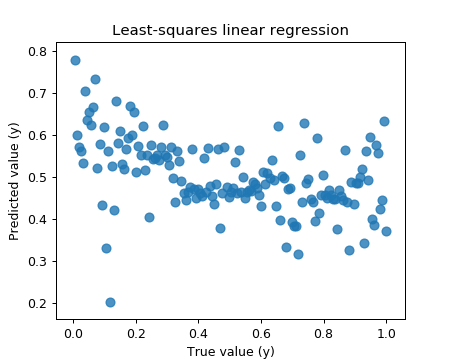

In [15]:
plt.figure(figsize=(5,4))
plt.scatter(y_test_nmpy, y_pred_model,marker= 'o', s=50, alpha=0.8)
#plt.plot(y_test_nmpy, y_pred_model, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('True value (y)')
plt.ylabel('Predicted value (y)')
plt.show()